# Preamble

In [1]:
%matplotlib widget

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val_outside = alpha0*f27lc(alpha0, 2)
f2val_outside = alpha0*f31lc(alpha0, 2)

IPython console for SymPy 1.11.1 (Python 3.11.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



# Poisson Bracket

In [2]:
class PoissonBracket:
    def __init__(self, q, p):
        """
        q : list of canonical coordinates
        p : list of canonical momenta
        """
        self.dim = len(q)
        if len(p) != self.dim:
            raise Warning("Mismatch in canonical conjugate pair dimensions.")
        self.q = q
        self.p = p
    def __call__(self, f, g):
        """
        f, g : Functions of canonical conjugate pairs p, q
        """
        bracket = 0
        for i in range(self.dim):
            bracket += f.diff(self.p[i])*g.diff(self.q[i]) - g.diff(self.p[i])*f.diff(self.q[i])
        return(bracket)

# Outer TP Hamiltonian

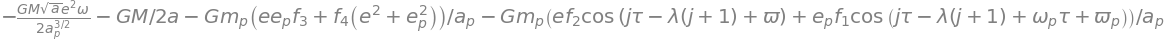

In [3]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
)
display(calH)

# Canonical variables and canonical transformations

In [4]:
def to_canonical(expr):
    return expr.subs({a: L**2, e: sqrt(2 * G / L), pom: -g})


def to_orbelts(expr):
    # This uses the approximation G=1/2*L*e^2
    return expr.subs({g: -pom, G: Rational(1, 2) * L * e**2, L: sqrt(a)})


def is_solve_multiple(sol):
    if len(sol) > 1:
        print(
            f"Solve for coordinate/momentum is multiple... {sol}, choosing the first solution."
        )
    return sol[0]


def F2_canTran(H, F2, q, P, Q, p, t):
    """
    F2: expression for generating function F_2(q,P)

    q : list of old canonical coordinates
    P : list of new canonical momenta

    Q : list of new canonical coordinates
    p : list of old canonical momenta
    """
    N = len(q)

    for var in [P, Q, p]:
        if len(var) != N:
            raise Warning("Must have same number of new and old variables.")

    Q_qP = []
    p_qP = []
    for i in range(len(q)):
        Q_qP += [F2.diff(P[i])]
        p_qP += [F2.diff(q[i])]

    P_Qp = []
    q_Qp = []
    for i in range(N):
        sol = solve([p[i] - p_qP[i], Q[i] - Q_qP[i]], [q[i], P[i]])
        try:
            q_Qp += [sol[q[i]]]
            P_Qp += [sol[P[i]]]
        except TypeError:
            q_Qp += [is_solve_multiple(sol)[0]]
            P_Qp += [is_solve_multiple(sol)[1]]

    p_QP = []
    q_QP = []
    for i in range(N):
        sol = solve(p[i] - p_qP[i].subs(q[i], q_Qp[i]), p[i])
        p_QP += [is_solve_multiple(sol)]

        sol = solve(q[i] - q_Qp[i].subs(p[i], p_qP[i]), q[i])
        q_QP += [is_solve_multiple(sol)]

    Q_qp = []
    P_qp = []
    for i in range(N):
        sol = solve(Q[i] - Q_qP[i].subs(P[i], P_Qp[i]), Q[i])
        Q_qp += [is_solve_multiple(sol)]

        sol = solve(P[i] - P_Qp[i].subs(Q[i], Q_qP[i]), P[i])
        P_qp += [is_solve_multiple(sol)]

    new_H = H.copy() + F2.diff(t)
    coords = {}
    for i in range(N):
        new_H = new_H.subs({q[i]: q_QP[i], p[i]: p_QP[i]})
        coords[q[i]] = q_QP[i]
        coords[p[i]] = p_QP[i]
        coords[Q[i]] = Q_qp[i]
        coords[P[i]] = P_qp[i]
    

    return coords, new_H

In [5]:
# Not working currently... can't solve for g. Use PB instead to check canonical Cartesian trafo.
#X, Y = symbols("X Y")
#genFunc = Rational(1, 2) * Y**2 * tan(g)
#display(genFunc)
#coords, H1 = F2_canTran(H, genFunc, [g], [Y], [X], [G])

# Hamiltonian

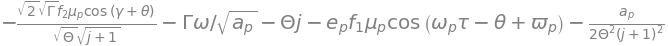

In [6]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

# CER

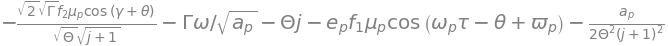

In [7]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

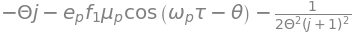

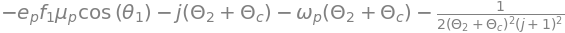

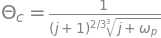

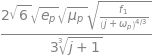

In [8]:
Hcer = H1.subs({f2:0,a_p:1,om:0,pom_p:0})
display(Hcer)
Th1, th1 = symbols("Theta_1 theta_1")
S1 = Th1*(th-om_p*tau)
display(Eq(th,solve(th1-S1.diff(Th1),th)[0]))
display(Eq(Th,S1.diff(th)))
Hcer = Hcer.subs({Th:Th1,th:solve(th1-S1.diff(Th1),th)[0]}) + S1.diff(tau)

Th2, th2, Thc = symbols("Theta_2 theta_2 Theta_c")
S2 = th1*(Th2+Thc)
display(S2)
display(Eq(th1, solve(th2-S2.diff(Th2),th1)[0] ))
Th2_expr = solve(Th1-S2.diff(th1),Th2)[0]
display(Eq(Th2, Th2_expr ))

Hcer=Hcer.subs({Th1:solve(Th1-S2.diff(th1),Th1)[0]})
display(Hcer)
#
Thc_expr = 1/(j+om_p)**Rational(1,3)/(j+1)**Rational(2,3)
display(Eq(Thc,Thc_expr))
display(Hcer.diff(Th2).subs(Th2,0).subs(Thc,Thc_expr))
#
Hcer0 = Hcer.taylor_term(0,Th2) + Hcer.taylor_term(1,Th2) + Hcer.taylor_term(2,Th2)
Hcer0 = Hcer0-Hcer0.args[1]-Hcer0.args[2]-Hcer0.args[3]
Hcer0 = Hcer0.subs(Thc,Thc_expr)
#Hcer0 = Hcer0 #- Hcer0.args[0]- Hcer0.args[1]- Hcer0.args[2]
WTh2 = 2*solve(Hcer0.subs(th1,pi),Th2)[1]
display(WTh2)

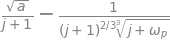

In [9]:
Th2_expr.subs(Th1,Th).subs(Th,coords_thTh[Th].subs(L,sqrt(a))).subs(Thc,Thc_expr)

# LER 

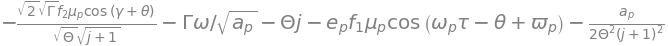

In [10]:
H = to_canonical(calH)
th, Th = symbols("theta Theta")
genFunc = Th * ((j + 1) * l - j * tau)
coords_thTh, H1 = F2_canTran(H, genFunc, [l], [Th], [th], [L], tau)
H1 = H1.simplify()
display(H1)

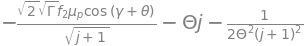

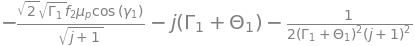

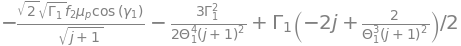

- \frac{\sqrt{2} \sqrt{\Gamma_{1}} f_{2} \mu_{p} \cos{\left(\gamma_{1} \right)}}{\sqrt{j + 1}} - \frac{3 \Gamma_{1}^{2}}{2 \Theta_{1}^{4} \left(j + 1\right)^{2}} + \frac{\Gamma_{1} \left(- 2 j + \frac{2}{\Theta_{1}^{3} \left(j + 1\right)^{2}}\right)}{2}


In [11]:
Hler = H1.subs({f1:0,a_p:1,om:0,pom_p:0,f2:f2*sqrt(Th)})
display(Hler)

G1, g1 = symbols("Gamma_1 gamma_1")
S1 = G1 * (th + g) + Th1 * th
display(S1)
th_expr = solve(th1 - S1.diff(Th1), th)[0]
display(Eq(th, th_expr))
Th1_expr = solve(Th - S1.diff(th), Th1)[0]
display(Eq(Th1, Th1_expr))
Th_expr = S1.diff(th)
display(Eq(Th, Th_expr))
G_expr = S1.diff(g)
display(Eq(G, G_expr))

g_expr = solve(g1 - S1.diff(G1), g)[0]
display(Eq(g, g_expr))
G1_expr = solve(G - S1.diff(g), G1)[0]
display(Eq(G1, G1_expr))

Hler = Hler.subs({g: g_expr, Th: Th_expr, G: G_expr})


display(Hler)

display(Hler.taylor_term(3, sqrt(G1)))
Hler = (
    #Hler.taylor_term(0, sqrt(G1))
     Hler.taylor_term(1, sqrt(G1))
    + Hler.taylor_term(2, sqrt(G1))
    + Hler.taylor_term(3, sqrt(G1))
    + Hler.taylor_term(4, sqrt(G1))
)

display(Hler)
print(latex(Hler))


#X, Y = symbols("X,Y")
#Hler = Hler.subs({G1:Rational(1,2)*(X**2+Y**2)})
#
#display(Hler.diff(Y).subs({X:0}))

# Conserved Quantities

In [12]:
Hcons = H1.subs({f1:0,a_p:1,om:0})
K_1, K_2, k_1, k_2 = symbols("K_1 K_2 k_1 k_2")
genFunc1 = K_1*(th+g) + K_2*th
genFunc1

In [13]:
genFunc1.diff(g)

In [14]:
genFunc1.diff(th)

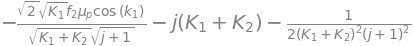

In [15]:
Hcons.subs(Th,genFunc1.diff(th)).subs(G,genFunc1.diff(g)).subs(g,k_1-th)

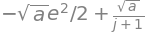

In [16]:
K2_expr = (Th-G).subs({G:Rational(1,2)*sqrt(a)*e**2,Th:sqrt(a)/(j+1)})
K2_expr